# Import package


In [ ]:
import requests
import autograd.numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from autograd import grad, jacobian
from scipy.optimize import minimize
import datetime
from typing import List
from numba import njit
import warnings
import numpy.linalg as la
import time

# Data import and processing


## Online

In [2]:
settledate = pd.to_datetime(datetime.date.today())
bonds = pd.DataFrame(
    json.loads(
        requests.get(
            "https://asx.api.markitdigital.com/asx-research/1.0/bonds/government/exchange-traded?height=179&width=690"
        ).content
    )["data"]["items"]
)
bonds["maturity"] = bonds["securityDescription"].str.extract(r"(\d{2}-\d{2}-\d{2})")[0]
bonds["maturity"] = pd.to_datetime(bonds["maturity"], format="%d-%m-%y")
bonds = bonds[["maturity", "couponPercent", "priceBid", "priceAsk"]]
bonds["couponPercent"] = bonds["couponPercent"].astype(float) / 100
bonds.dropna(inplace=True)
bonds.sort_values("maturity", inplace=True)
bonds.reset_index(drop=True, inplace=True)
bonds.to_csv(f"data/bonds_{settledate.strftime('%Y%m%d')}.csv", index=False)
bonds

,maturity,couponPercent,priceBid,priceAsk
0,2025-11-21,0.0025,98.350,98.410
1,2026-04-21,0.0425,101.000,101.280
2,2026-09-21,0.0050,96.244,96.544
3,2027-04-21,0.0475,102.900,103.110
4,2027-11-21,0.0275,98.410,98.640
5,2028-05-21,0.0225,96.600,96.830
6,2028-11-21,0.0275,97.505,97.773
7,2029-04-21,0.0325,99.149,99.410
8,2029-11-21,0.0275,96.330,96.570
9,2030-05-21,0.0250,94.524,95.024


## Offline

In [3]:
settledate = pd.to_datetime("2025-05-18")
bonds = pd.read_csv(f"data/bonds_{settledate.strftime('%Y%m%d')}.csv")
bonds["maturity"] = pd.to_datetime(bonds["maturity"])
bonds

,maturity,couponPercent,priceBid,priceAsk
0,2025-11-21,0.0025,98.00,99.95
1,2026-04-21,0.0425,100.81,103.00
2,2027-04-21,0.0475,102.10,103.32
3,2027-11-21,0.0275,97.50,98.22
4,2028-05-21,0.0225,96.00,96.37
5,2029-04-21,0.0325,97.00,99.82
6,2033-04-21,0.0450,101.65,103.50
7,2034-12-21,0.0350,92.70,96.83
8,2037-04-21,0.0375,93.00,93.30
9,2039-06-21,0.0325,85.75,92.00


# Support function


In [4]:
def year_transform(date: pd.Timestamp) -> float:
    """Transform date to actual year"""
    if date == settledate:
        return 0
    years = date.year - settledate.year
    check_date = pd.Timestamp(
        year=date.year,
        month=settledate.month,
        day=settledate.day,
    )
    years += (date - check_date).days / abs(
        (
            check_date
            + pd.DateOffset(years=np.sign((date - check_date).days))
            - check_date
        ).days
    )
    return years


def coupon_date_generate(maturity: pd.Timestamp) -> np.ndarray:
    """Generate coupon dates"""
    coupon_dates = [maturity]
    while maturity - pd.DateOffset(months=6) > settledate:
        maturity -= pd.DateOffset(months=6)
        coupon_dates.append(maturity)
    return np.array(list(map(year_transform, coupon_dates[::-1])))

# Discount factor curve


In [5]:
def plot(params: np.ndarray, func: callable) -> None:
    t = np.linspace(0, 30, 100000)
    dfs = func(params, t)
    plt.figure(figsize=(15, 6))
    plt.plot(t, dfs)
    plt.title("Discount Factor Curve")
    plt.xlabel("Years")
    plt.ylabel("Discount Factor")
    plt.grid()
    plt.show()

# Basic function


## Discount factor function


In [6]:
# @njit(cache=True)
def discount_factor(params: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Calculate discount factor"""
    f0 = params[0]
    f1 = params[1]
    f2 = params[2]
    gamma = params[3]
    if gamma == 0:
        return np.exp(-f0 * t)
    if gamma < 0:
        raise ValueError("Gamma must be positive")
    res = -(
        f0 * t
        + f1 * (gamma - np.exp(-t / gamma) * gamma)
        + f2 * (gamma - np.exp(-t / gamma) * (t + gamma))
    )
    return np.exp(res)

## Bond valuation function


In [7]:
# @njit(cache=True)
def bond_valuation(params: np.ndarray, t: np.ndarray, coupon: float) -> float:
    """Calculate bond valuation"""
    cf = np.ones_like(t) * coupon / 2
    cf[-1] += 1
    return 100 * np.sum(cf * discount_factor(params, t))

## Loss function component


In [8]:
# @njit(cache=True)
def loss_function_component(
    params: np.ndarray, t: np.ndarray, coupon: float, bid: float, ask: float
) -> float:
    """Objective function for optimization"""
    bond_price = bond_valuation(params, t, coupon)
    if np.abs(bond_price) >= 1e154:
        return np.inf
    return (max(0, bond_price - ask) / ask) ** 2 + (max(0, bid - bond_price) / bid) ** 2

# Analytical


## Gradient function


In [9]:
# @njit(cache=True)
def discount_factor_gradient_analytical(
    params: np.ndarray, t: np.ndarray, element: int
) -> np.ndarray:
    """Calculate gradient of discount factor"""
    f0, f1, f2, gamma = params
    if element == 0:
        return -t * discount_factor(params, t)
    elif element == 1:
        return (-gamma + np.exp(-t / gamma) * gamma) * discount_factor(params, t)
    elif element == 2:
        return (-gamma + np.exp(-t / gamma) * (t + gamma)) * discount_factor(params, t)
    else:
        return (
            -f1 * (1 - np.exp(-t / gamma) - t * np.exp(-t / gamma) / gamma)
            - f2
            * (
                1
                - np.exp(-t / gamma)
                - t * np.exp(-t / gamma) * (t + gamma) / (gamma**2)
            )
        ) * discount_factor(params, t)


# @njit(cache=True)
def bond_valuation_gradient_analytical(
    params: np.ndarray, t: np.ndarray, coupon: float, element: int
) -> float:
    """Calculate gradient of bond valuation"""
    cf = np.ones_like(t) * coupon / 2
    cf[-1] += 1
    return 100 * np.sum(cf * discount_factor_gradient_analytical(params, t, element))


# @njit(cache=True)
def loss_function_component_gradient_analytical(
    params: np.ndarray,
    t: np.ndarray,
    coupon: float,
    bid: float,
    ask: float,
    element: int,
) -> float:
    """Calculate gradient of bond valuation"""
    vj = bond_valuation(params, t, coupon)
    if vj > ask:
        return (2 * (vj - ask) / (ask**2)) * bond_valuation_gradient_analytical(
            params, t, coupon, element
        )
    elif vj < bid:
        return (2 * (vj - bid) / (bid**2)) * bond_valuation_gradient_analytical(
            params, t, coupon, element
        )
    else:
        return 0.0

## Hessian Function


In [10]:
# @njit(cache=True)
def discount_factor_hessian_analytical(
    params: np.ndarray, t: np.ndarray, elements: List[int]
) -> np.ndarray:
    """Calculate hessian of discount factor"""
    f0, f1, f2, gamma = params
    sorted_elements = sorted(elements)
    if sorted_elements == [0, 0]:
        return t**2 * discount_factor(params, t)
    elif sorted_elements == [0, 1]:
        return -t * (-gamma + np.exp(-t / gamma) * gamma) * discount_factor(params, t)
    elif sorted_elements == [0, 2]:
        return (
            -t
            * (-gamma + np.exp(-t / gamma) * (t + gamma))
            * discount_factor(params, t)
        )
    elif sorted_elements == [0, 3]:
        return (
            -t
            * (
                -f1 * (1 - np.exp(-t / gamma) - t * np.exp(-t / gamma) / gamma)
                - f2
                * (
                    1
                    - np.exp(-t / gamma)
                    - t * np.exp(-t / gamma) * (t + gamma) / (gamma**2)
                )
            )
            * discount_factor(params, t)
        )
    elif sorted_elements == [1, 1]:
        return ((-gamma + np.exp(-t / gamma) * gamma) ** 2) * discount_factor(params, t)
    elif sorted_elements == [1, 2]:
        return (
            (-gamma + np.exp(-t / gamma) * gamma)
            * (-gamma + np.exp(-t / gamma) * (t + gamma))
            * discount_factor(params, t)
        )
    elif sorted_elements == [1, 3]:
        return (
            (-1 + np.exp(-t / gamma) + np.exp(-t / gamma) * t / gamma) * (f1 + 1)
            - f2
            * (
                1
                - np.exp(-t / gamma)
                - t * (t + gamma) * np.exp(-t / gamma) / (gamma**2)
            )
        ) * discount_factor(params, t)
    elif sorted_elements == [2, 2]:
        return ((-gamma + np.exp(-t / gamma) * (t + gamma)) ** 2) * discount_factor(
            params, t
        )
    elif sorted_elements == [2, 3]:
        return (
            (-1 + np.exp(-t / gamma) + np.exp(-t / gamma) * t / gamma)
            * (1 + f1 * (-gamma + np.exp(-t / gamma) * (t + gamma)))
            - (-gamma + np.exp(-t / gamma) * (t + gamma))
            * (
                1
                - np.exp(-t / gamma)
                - np.exp(-t / gamma) * t * (t + gamma) / (gamma**2)
            )
            * f2
        ) * discount_factor(params, t)
    else:
        return (
            np.exp(-t / gamma) * (t**2) * f1 / (gamma**3)
            - (
                -2 * np.exp(-t / gamma) * t / (gamma**2)
                - np.exp(-t / gamma) * (t**2) * (t + gamma) / (gamma**4)
                + 2 * np.exp(-t / gamma) * t
                + (t + gamma) / (gamma**3)
            )
            * f2
            + (
                f1 * (1 - np.exp(-t / gamma) - np.exp(-t / gamma) * t / gamma)
                + f2
                * (
                    1
                    - np.exp(-t / gamma)
                    - np.exp(-t / gamma) * t * (t + gamma) / (gamma**2)
                )
            )
            ** 2
        ) * discount_factor(params, t)


# @njit(cache=True)
def bond_valuation_hessian_analytical(
    params: np.ndarray, t: np.ndarray, coupon: float, elements: List[int]
) -> float:
    """Calculate hessian of bond valuation"""
    cf = np.ones_like(t) * coupon / 2
    cf[-1] += 1
    return 100 * np.sum(cf * discount_factor_hessian_analytical(params, t, elements))


# @njit(cache=True)
def loss_function_component_hessian_analytical(
    params: np.ndarray,
    t: np.ndarray,
    coupon: float,
    bid: float,
    ask: float,
    elements: List[int],
) -> float:
    """Calculate hessian of loss component"""
    vj = bond_valuation(params, t, coupon)
    if vj > ask:
        return (2 * (vj - ask) / (ask**2)) * bond_valuation_hessian_analytical(
            params, t, coupon, elements
        ) + (2 / (ask**2)) * bond_valuation_gradient_analytical(
            params, t, coupon, elements[0]
        ) * bond_valuation_gradient_analytical(
            params, t, coupon, elements[1]
        )
    elif vj < bid:
        return (2 * (vj - bid) / (bid**2)) * bond_valuation_hessian_analytical(
            params, t, coupon, elements
        ) + (2 / (bid**2)) * bond_valuation_gradient_analytical(
            params, t, coupon, elements[0]
        ) * bond_valuation_gradient_analytical(
            params, t, coupon, elements[1]
        )
    else:
        return 0.0

# Numerical


## Gradient function


In [11]:
# @njit(cache=True)
def loss_function_component_gradient_numerical(
    params: np.ndarray,
    t: np.ndarray,
    coupon: float,
    bid: float,
    ask: float,
    element: int,
    tolerance: float = 1e-15,
) -> float:
    """Calculate gradient of bond valuation"""
    param_forward = params.copy()
    param_forward[element] += tolerance
    param_backward = params.copy()
    param_backward[element] -= tolerance
    lj_forward = loss_function_component(param_forward, t, coupon, bid, ask)
    lj_backward = loss_function_component(param_backward, t, coupon, bid, ask)
    return (lj_forward - lj_backward) / (2 * tolerance)

## Hessian function


In [12]:
# @njit(cache=True)
def loss_function_component_hessian_numerical(
    params: np.ndarray,
    t: np.ndarray,
    coupon: float,
    bid: float,
    ask: float,
    elements: List[int],
    tolerance: float = 1e-15,
) -> float:
    """Calculate hessian of loss component"""
    new_elements = elements.copy()
    elements = sorted(new_elements)
    param_f_f = params.copy()
    param_f_b = params.copy()
    param_b_f = params.copy()
    param_b_b = params.copy()
    param_f_f[elements[0]] += tolerance
    param_f_f[elements[1]] += tolerance
    param_f_b[elements[0]] += tolerance
    param_f_b[elements[1]] -= tolerance
    param_b_f[elements[0]] -= tolerance
    param_b_f[elements[1]] += tolerance
    param_b_b[elements[0]] -= tolerance
    param_b_b[elements[1]] -= tolerance
    lj_f_f = loss_function_component(param_f_f, t, coupon, bid, ask)
    lj_f_b = loss_function_component(param_f_b, t, coupon, bid, ask)
    lj_b_f = loss_function_component(param_b_f, t, coupon, bid, ask)
    lj_b_b = loss_function_component(param_b_b, t, coupon, bid, ask)
    return (lj_f_f - lj_f_b - lj_b_f + lj_b_b) / (4 * tolerance**2)

# Optimizing function


In [ ]:
def constrained_target(params: np.ndarray) -> float:
    """Target function to be minimized"""
    return np.sum(
        [
            loss_function_component(
                params,
                coupon_date_generate(row["maturity"]),
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )

In [ ]:
def unconstrained_target(params: np.ndarray) -> float:
    """Target function to be minimized"""
    return np.sum(
        [
            loss_function_component(
                np.array([params[0], params[1], params[2], np.exp(params[3])]),
                coupon_date_generate(row["maturity"]),
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )

## Library method for components


In [14]:
jac_library = grad(target)
hess_library = jacobian(grad(target))

## Analytical method for components


In [15]:
def jac_analytical(params: np.ndarray) -> np.ndarray:
    """Calculate jacobian using analytical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_gradient_analytical(
                        params,
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        element,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
        ]
    )


def hess_analytical(params: np.ndarray) -> np.ndarray:
    """Calculate hessian using analytical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_hessian_analytical(
                        params,
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        [element, element2],
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
            for element2 in range(len(params))
        ]
    ).reshape(len(params), len(params))

## Numerical method for components


In [16]:
def jac_numerical(params: np.ndarray, tolerance: float = 1e-5) -> np.ndarray:
    """Calculate jacobian using numerical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_gradient_numerical(
                        params,
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        element,
                        tolerance=tolerance,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
        ]
    )


def hess_numerical(params: np.ndarray, tolerance: float = 1e-4) -> np.ndarray:
    """Calculate hessian using numerical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_hessian_numerical(
                        params,
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        [element, element2],
                        tolerance=tolerance,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
            for element2 in range(len(params))
        ]
    ).reshape(len(params), len(params))

# Comparing methods

# Scipy Benchmarking 
- Numpy has to be used for SciPy’s optimizers, imported as onp to avoid confusion

### Helper functions

In [ ]:
from scipy.optimize import OptimizeResult

def result_to_df(res: OptimizeResult, param_names: list[str] = None, df: pd.DataFrame = None) -> pd.DataFrame:
    """
    Convert a scipy OptimizeResult into a pandas DataFrame row, appending to an existing df if provided.

    Parameters
    ----------
    res : OptimizeResult
        The result object returned by scipy.optimize.minimize (or similar).
    param_names : list of str, optional
        Names for the elements of res.x. If None, defaults to ['x0','x1',...].
    df : pandas.DataFrame, optional
        Existing DataFrame to which the new row will be appended. If None, a new DataFrame is created.

    Returns
    -------
    df_out : pandas.DataFrame
        DataFrame with the new result row added at the end.
    """
    # Ensure res.x is array
    x = np.atleast_1d(res.x)
    n = x.shape[0]
    # Determine param names
    if param_names is None:
        param_names = [f"f{i}" for i in range(n)]
        param_names[n-1] = "gamma"
    elif len(param_names) != n:
        raise ValueError(f"param_names length {len(param_names)} != len(res.x) {n}")
    # Build row dict
    row = {name: float(val) for name, val in zip(param_names, x)}
    # Standard OptimizeResult attributes
    for attr in ("fun", "nit", "nfev", "njev", "status"):  # numeric
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    for attr in ("success", "message"):  # boolean or text
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    # Create or append to DataFrame
    row_df = pd.DataFrame([row])
    if df is None:
        return row_df
    else:
        # preserve column order: union of existing and new
        return pd.concat([df, row_df], ignore_index=True)

# Example usage:
# df = None
# df = result_to_df(res_pr, param_names=['beta0','beta1','beta2','eta'], df=df)
# df = result_to_df(res_bfgs, param_names=['beta0','beta1','beta2','eta'], df=df)
# df['gamma'] = np.exp(df['eta'])
# print(df)
# df_pr = result_to_df(res_pr, param_names=['beta0','beta1','beta2','eta'])
# df_pr['gamma'] = np.exp(df_pr['eta'])
# print(df_pr)

In [ ]:
# recover the true gamma
def true_gamma(res):
    beta0, beta1, beta2, eta_opt = res.x
    gamma_opt = np.exp(eta_opt)
    print("Optimized NS params:", [beta0, beta1, beta2, gamma_opt])
    print("Final loss:", res.fun)

In [ ]:
np.exp(0.1)

1.1051709180756477

In [ ]:
# the constrained‐to‐unconstrained wrapper
def target_unconstrained(phi):
    # unpack
    beta0, beta1, beta2, eta = phi
    # enforce gamma>0 via exp (reparameterization)
    gamma = np.exp(eta)
    # rebuild the full NS params vector
    params = np.array([beta0, beta1, beta2, gamma])
    # call your original target (which expects gamma>0)
    return target(params)

### Data Setup

In [ ]:
import numpy as onp 

# AUTOGRAD grad / hessian
grad_ag = grad(target) 
hess_ag = hessian(target)

# Convert AUTOGRAD -> numpy
fun   = lambda x: float( target(np.array(x)) )
jac   = lambda x: onp.array( grad(target)(np.array(x)) )
hessp = lambda x,p: onp.array( hessian(target)(np.array(x)).dot(p) )
hess  = lambda x: onp.array( hessian(target)(np.array(x)) )

# shared x0 + bounds
x0   = onp.ones(4) * 0.415
bnds = [(-onp.inf, onp.inf)]*3 + [(1e-8, onp.inf)]
bobj = Bounds(*zip(*bnds))

In [ ]:
# make autodiff versions
grad_uncon = grad(target_unconstrained)

# boundary lambdas that convert ArrayBox → float / ndarray
fun_uncon = lambda y: float( target_unconstrained(np.array(y)) )
jac_uncon = lambda y: onp.array( grad_uncon(np.array(y)) )

# initial guess + (no bounds on y, since gamma = exp(eta) is always >0)
y0 = onp.array([0.415, 0.415, 0.415, onp.log(0.415)])

# Prepare a container for histories
histories = {}

### Conjugate Gradient (CG, Polak–Ribiere: variety of Fletcher–Reeves)

In [ ]:
losses_cg = []
times_cg  = []
t0 = time.perf_counter()

def cb_cg(xk):
    # xk is the current iterate
    losses_cg.append(fun_uncon(xk))
    times_cg .append(time.perf_counter() - t0)

# CG (Polak–Ribière nonlinear conjugate‐gradient algorithm (with occasional restarts))
res_pr = minimize(
    fun_uncon,
    y0,
    jac=jac_uncon,
    method='CG',
    callback=cb_cg,
    options={'gtol':1e-6, 'maxiter':300}
)
histories["CG"] = {"loss": losses_cg, "time": times_cg}
res_pr

 message: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 2.339683544160287e-05
       x: [ 5.641e-02 -1.621e-02 -2.696e-02  1.166e+00]
     nit: 500
     jac: [ 1.187e-05 -3.583e-04  6.537e-06 -4.538e-05]
    nfev: 1234
    njev: 1225

In [ ]:
if res_pr.success:
    print(true_gamma(res_pr))

In [ ]:
performances = result_to_df(res_pr)
performances

,f0,f1,f2,gamma,fun,nit,nfev,njev,status,success,message
0,0.056412,-0.016214,-0.026959,1.166028,0.000023,500,1234,1225,1,False,Maximum number of iterations has been exceeded.


### Newton-CG & Trust-Region Newton

In [ ]:
losses_ncg = []
times_ncg  = []
t0 = time.perf_counter()
def cb_ncg(xk):
    losses_ncg.append(fun_uncon(xk))
    times_ncg .append(time.perf_counter() - t0)
    
res_newton = minimize(
    fun=target_unconstrained,
    x0=x0,
    jac=jac_uncon,
    hessp=hessp,
    method='Newton-CG',
    callback=cb_ncg,
    options={'xtol':1e-8, 'maxiter':300}
)

histories["Newton-CG"] = {"loss": losses_ncg, "time": times_ncg}

In [ ]:
print("Newton-CG →", res_newton.x, res_newton.fun)
if res_newton.success:
    print(true_gamma(res_newton))
res_newton

Newton-CG → [ 0.05376893  0.0052494  -0.06391594  0.36588235] 0.00023731697579235656


 message: Warning: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 0.00023731697579235656
       x: [ 5.377e-02  5.249e-03 -6.392e-02  3.659e-01]
     nit: 500
     jac: [-4.334e-03 -4.227e-04 -4.016e-04 -6.442e-04]
    nfev: 618
    njev: 618
    nhev: 1099

In [ ]:
performances = result_to_df(res_newton, df=performances)
performances

,f0,f1,f2,gamma,fun,nit,nfev,njev,status,success,message
0,0.056412,-0.016214,-0.026959,1.166028,0.000023,500,1234,1225,1,False,Maximum number of iterations has been exceeded.
1,0.053769,0.005249,-0.063916,0.365882,0.000237,500,618,618,1,False,Warning: Maximum number of iterations has been...


### L-BFGS-B

In [ ]:
losses_lbfgsb = []
times_lbfgsb  = []
t0 = time.perf_counter()
def cb_lbfgsb(xk):
    losses_lbfgsb.append(fun_uncon(xk))
    times_lbfgsb.append(time.perf_counter() - t0)

res_L_BFGS_B = minimize(
    fun=fun,
    x0=x0,
    jac=jac,
    bounds=bnds,
    method='L-BFGS-B',
    options={'ftol':1e-9, 'maxiter':300}
)
histories["L-BFGS-B"] = {"loss": losses_lbfgsb, "time": times_lbfgsb}
res_L_BFGS_B 

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.004001907495163986
        x: [ 4.698e-02  5.368e-02  9.224e-02  1.000e-08]
      nit: 15
      jac: [-8.819e-08  1.841e-09  1.841e-09  2.686e-02]
     nfev: 29
     njev: 29
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [ ]:
performances = result_to_df(res_L_BFGS_B, df=performances)
performances

,f0,f1,f2,gamma,fun,nit,nfev,njev,status,success,message
0,0.056412,-0.016214,-0.026959,1.166028e+00,0.000023,500,1234,1225,1,False,Maximum number of iterations has been exceeded.
1,0.053769,0.005249,-0.063916,3.658824e-01,0.000237,500,618,618,1,False,Warning: Maximum number of iterations has been...
2,0.046975,0.053675,0.092239,1.000000e-08,0.004002,15,29,29,0,True,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


### BFGS

In [ ]:
losses_bfgs = []
times_bfgs  = []
t0 = time.perf_counter()
def cb_bfgs(y):
    losses_bfgs.append(fun_uncon(y))
    times_bfgs.append(time.perf_counter() - t0)

res_bfgs = minimize(
    fun=fun_uncon,
    x0=y0,
    jac=jac_uncon,
    method='BFGS',
    callback=cb_bfgs,
    options={'gtol':1e-6, 'maxiter':300}
)
histories["BFGS"] = {"loss": losses_bfgs, "time": times_bfgs}

In [ ]:
if res_bfgs.success:
    print(true_gamma(res_bfgs))
res_bfgs

Optimized NS params: [0.06640518105546138, -0.02912257685457828, 5.469370055665931e-07, 17.82710611762944]
Final loss: 1.3138694761566659e-05
None


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.3138694761566659e-05
        x: [ 6.641e-02 -2.912e-02  5.469e-07  2.881e+00]
      nit: 105
      jac: [-1.511e-08 -6.346e-08  1.721e-08 -4.931e-10]
 hess_inv: [[ 4.945e+00 -4.359e+00  4.044e+00  4.431e+02]
            [-4.359e+00  3.864e+00 -3.214e+00 -3.764e+02]
            [ 4.044e+00 -3.214e+00  1.825e+03  6.293e+04]
            [ 4.431e+02 -3.764e+02  6.293e+04  2.189e+06]]
     nfev: 140
     njev: 140

In [ ]:
performances = result_to_df(res_bfgs, df=performances)
performances

,f0,f1,f2,gamma,fun,nit,nfev,njev,status,success,message
0,0.056412,-0.016214,-2.695919e-02,1.166028e+00,0.000023,500,1234,1225,1,False,Maximum number of iterations has been exceeded.
1,0.053769,0.005249,-6.391594e-02,3.658824e-01,0.000237,500,618,618,1,False,Warning: Maximum number of iterations has been...
2,0.046975,0.053675,9.223946e-02,1.000000e-08,0.004002,15,29,29,0,True,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
3,0.066405,-0.029123,5.469370e-07,2.880720e+00,0.000013,105,140,140,0,True,Optimization terminated successfully.


### SLSQP (General Constrained NLP)

In [ ]:
losses_slsqp = []
times_slsqp  = []
t0 = time.perf_counter()
def cb_slsqp(xk):
    losses_slsqp.append(fun(xk))
    times_slsqp.append(time.perf_counter() - t0)

res_slsqp = minimize(
    fun=fun,
    x0=x0,
    jac=jac,
    bounds=bobj,
    method='SLSQP',
    callback=cb_slsqp,
    options={'ftol':1e-9, 'maxiter':300}
)
histories["SLSQP"] = {"loss": losses_slsqp, "time": times_slsqp}
res_slsqp

/opt/conda/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwar

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.3318483411992904e-05
       x: [ 6.883e-02 -3.150e-02 -9.709e-03  1.392e+01]
     nit: 88
     jac: [ 2.810e-04  1.142e-04  9.457e-05 -2.314e-07]
    nfev: 113
    njev: 88

In [ ]:
performances = result_to_df(res_slsqp, df=performances)
performances

,f0,f1,f2,gamma,fun,nit,nfev,njev,status,success,message
0,0.056412,-0.016214,-2.695919e-02,1.166028e+00,0.000023,500,1234,1225,1,False,Maximum number of iterations has been exceeded.
1,0.053769,0.005249,-6.391594e-02,3.658824e-01,0.000237,500,618,618,1,False,Warning: Maximum number of iterations has been...
2,0.046975,0.053675,9.223946e-02,1.000000e-08,0.004002,15,29,29,0,True,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
3,0.066405,-0.029123,5.469370e-07,2.880720e+00,0.000013,105,140,140,0,True,Optimization terminated successfully.
4,0.068826,-0.031502,-9.709058e-03,1.391610e+01,0.000013,88,113,88,0,True,Optimization terminated successfully


### Trust-constr (General Constrained NLP)

In [ ]:
losses_trust = []
times_trust  = []
t0 = time.perf_counter()
def cb_trust(xk, state):
    # trust-constr callback signature takes (xk, OptimizeResult)
    losses_trust.append(fun_uncon(xk))
    times_trust .append(time.perf_counter() - t0)

res_trust = minimize(
    fun=fun,
    x0=x0,
    jac=jac,
    hess=hess,
    bounds=bobj,
    method='trust-constr',
    callback=cb_trust,
    options={'gtol':1e-8, 'maxiter':300}
)
histories["Trust-constr"] = {"loss": losses_trust, "time": times_trust}
res_trust

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 1.3150189463564015e-05
                 x: [ 6.578e-02 -2.850e-02 -4.831e-03  1.451e+01]
               nit: 283
              nfev: 236
              njev: 186
              nhev: 186
          cg_niter: 588
      cg_stop_cond: 4
              grad: [-3.066e-10  2.232e-10  5.349e-10 -8.601e-09]
   lagrangian_grad: [-3.066e-10  2.232e-10  5.349e-10 -9.263e-09]
            constr: [array([ 6.578e-02, -2.850e-02, -4.831e-03,  1.451e+01])]
               jac: [<4x4 sparse matrix of type '<class 'numpy.float64'>'
                    	with 4 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([ 0.000e+00,  0.000e+00,  0.000e+00, -6.616e-10])]
            method: tr_interior_point
        optimality: 9.262722460024076e-09
  constr_violation: 0.0
    execution_time: 22.

In [ ]:
performances = result_to_df(res_trust, df=performances)
performances

,f0,f1,f2,gamma,fun,nit,nfev,njev,status,success,message
0,0.056412,-0.016214,-2.695919e-02,1.166028e+00,0.000023,500,1234,1225,1,False,Maximum number of iterations has been exceeded.
1,0.053769,0.005249,-6.391594e-02,3.658824e-01,0.000237,500,618,618,1,False,Warning: Maximum number of iterations has been...
2,0.046975,0.053675,9.223946e-02,1.000000e-08,0.004002,15,29,29,0,True,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
3,0.066405,-0.029123,5.469370e-07,2.880720e+00,0.000013,105,140,140,0,True,Optimization terminated successfully.
4,0.068826,-0.031502,-9.709058e-03,1.391610e+01,0.000013,88,113,88,0,True,Optimization terminated successfully
5,0.065781,-0.028500,-4.830538e-03,1.451336e+01,0.000013,283,236,186,1,True,`gtol` termination condition is satisfied.


### View results

In [ ]:
performances["algo"] = ["CG", "Newton-CG", "L-BFGS-B", "BFGS", "SLSQP", "Trust-constr"]
performances

,f0,f1,f2,gamma,fun,nit,nfev,njev,status,success,message,algo
0,0.056412,-0.016214,-2.695919e-02,1.166028e+00,0.000023,500,1234,1225,1,False,Maximum number of iterations has been exceeded.,CG
1,0.053769,0.005249,-6.391594e-02,3.658824e-01,0.000237,500,618,618,1,False,Warning: Maximum number of iterations has been...,Newton-CG
2,0.046975,0.053675,9.223946e-02,1.000000e-08,0.004002,15,29,29,0,True,CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL,L-BFGS-B
3,0.066405,-0.029123,5.469370e-07,2.880720e+00,0.000013,105,140,140,0,True,Optimization terminated successfully.,BFGS
4,0.068826,-0.031502,-9.709058e-03,1.391610e+01,0.000013,88,113,88,0,True,Optimization terminated successfully,SLSQP
5,0.065781,-0.028500,-4.830538e-03,1.451336e+01,0.000013,283,236,186,1,True,`gtol` termination condition is satisfied.,Trust-constr


### Calculate the solution error

In [ ]:
# 1) find the reference row (smallest final loss)
ref_idx = performances['fun'].idxmin()
ref = performances.loc[ref_idx, ['f0','f1','f2','gamma']].to_numpy()

# 2) define a function to compute norm difference
def soln_error(row):
    est = row[['f0','f1','f2','gamma']].to_numpy()
    return onp.linalg.norm(est - ref)

# 3) apply to each row
performances['soln_error'] = performances.apply(soln_error, axis=1)

# 4) (optional) view the updated DataFrame
performances[['algo','soln_error']]

,algo,soln_error
0,CG,1.714982
1,Newton-CG,2.515916
2,L-BFGS-B,2.883451
3,BFGS,0.000000
4,SLSQP,11.035380
5,Trust-constr,11.632640


### Plot target func value over iterations and time

99th percentile loss: 5.8033988184159515


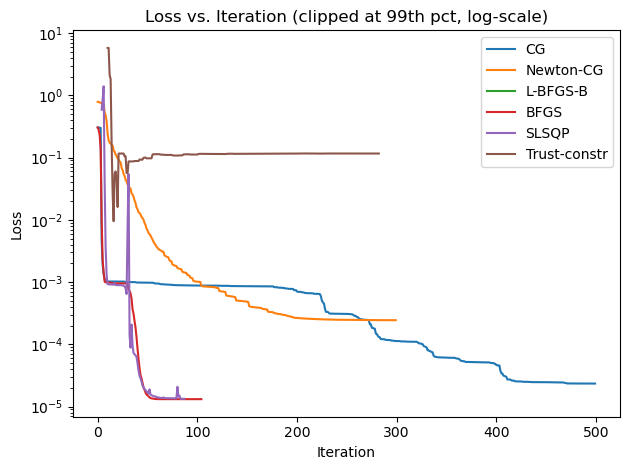

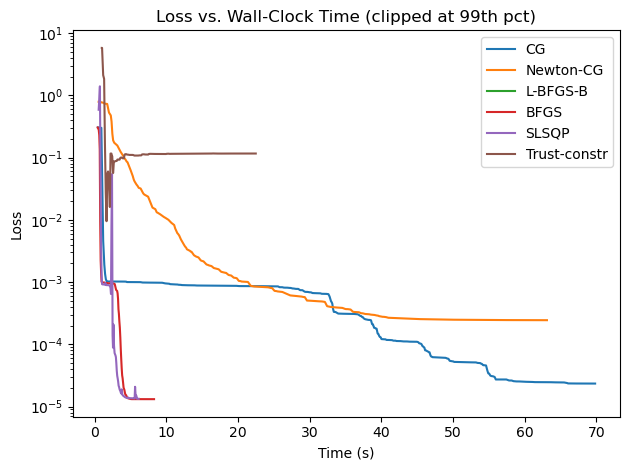

In [ ]:
# stack and filter finite losses
all_losses = onp.hstack([
    onp.array(h['loss'])[ onp.isfinite(h['loss']) ]
    for h in histories.values()
])

# high‐end cutoff (e.g. the 99th percentile)
cutoff = onp.percentile(all_losses, 99)
print("99th percentile loss:", cutoff)

plt.figure()
for name, h in histories.items():
    loss = onp.array(h['loss'])
    mask = onp.isfinite(loss) & (loss <= cutoff)
    plt.plot(onp.nonzero(mask)[0], loss[mask], label=name)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration (clipped at 99th pct, log-scale)')
plt.legend()
plt.tight_layout()
plt.savefig('loss_vs_iteration_clipped.pdf')
plt.show()

plt.figure()
for name, h in histories.items():
    loss = onp.array(h['loss'])
    time = onp.array(h['time'])
    # same mask as before
    mask = onp.isfinite(loss) & (loss <= cutoff)
    # plot time vs. loss
    plt.plot(time[mask], loss[mask], label=name)
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.title('Loss vs. Wall-Clock Time (clipped at 99th pct)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('loss_vs_time_clipped.pdf')
plt.show()

In [ ]:
# TODO: Soln Error
# 1. Pick a reference:  whichever solver gave you the lowest final loss or a trusted “ground truth” curve.
theta_ref = np.array([β0_ref, β1_ref, β2_ref, γ_ref])
theta_est = np.array([β0_est, β1_est, β2_est, γ_est])

soln_error = np.linalg.norm(theta_est - theta_ref)